# 1. Starter code

## 1.1. Data setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json

names = json.loads(open("../data/names.txt", "r").read())
names = names["payload"]["blob"]["rawLines"]
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Length of dataset: ", len(names))

Length of dataset:  32033


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(names))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi["."] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(chtoi)
print("chtoi: ", chtoi)
print("itoch: ", itoch)
print("vocab_size: ", vocab_size)

chtoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itoch:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size:  27


In [5]:
import random

def build_dataset(data, mode="tr", context_len=3):
  """
  Builds the dataset from the given list of words.
  
  Args:
    data (list): list of words to use
    mode (str): mode of the dataset (default: "tr" for training)
    context_len (int): length of the context window (default: 3)
  """
  
  X, y = [], []
  
  for word in data:
    context = [0] * context_len
    for ch in word + ".":
      ix = chtoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]
  
  X = torch.tensor(X)
  y = torch.tensor(y)
  
  print(f"X{mode}.shape: {X.shape}, y{mode}.shape: {y.shape}")
  return X, y


random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, ytr   = build_dataset(names[:n1]  , mode="tr")
Xval, yval = build_dataset(names[n1:n2], mode="val")
Xte, yte   = build_dataset(names[n2:]  , mode="te")

Xtr.shape: torch.Size([182461, 3]), ytr.shape: torch.Size([182461])
Xval.shape: torch.Size([22779, 3]), yval.shape: torch.Size([22779])
Xte.shape: torch.Size([22906, 3]), yte.shape: torch.Size([22906])


In [6]:
for X, y in zip(Xtr[:5], ytr[:5]):
  print("".join(itoch[ix.item()] for ix in X), ">", itoch[y.item()])

... > y
..y > a
.ya > r
yar > i
ari > e


## 1.2. Neural-layer classes definition

This segment reimplements the neural-layer classes from the previous notebooks and defines an API quite similar to PyTorch's.

In [7]:
import math

class Sequential:
  def __init__(self, name, layers):
    self.name = name
    self.layers = layers

  def __repr__(self):
    return self.name
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def params(self):
    return [p for layer in self.layers for p in layer.params()]

class Embedding:
  def __init__(self, vocab_size, emb_size):
    self.weight = torch.randn(vocab_size, emb_size) / math.sqrt(emb_size)

  def __repr__(self):
    return f"Embedding({self.weight.shape})"

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out

  def params(self):
    return [self.weight]
  
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def __repr__(self):
    return f"Flatten({self.out.shape})"

  def params(self):
    return []
  
class Linear:
  """
  This layer applies a linear transformation to its input, expressed as
  y = x @ W + b, where x is the input, W is the weight matrix and b is the bias.
  This layer is also known as a fully connected layer or a dense layer.
  """
  def __init__(self, fan_in, fan_out, kaiming=True, scaling=False, bias=True):
    self.gain = 5.0 / 3.0
    self.weight = torch.randn(fan_in, fan_out) / math.sqrt(fan_in)
    self.weight = self.weight * self.gain if kaiming else self.weight
    self.weight = self.weight * 0.1 if scaling else self.weight
    self.bias = torch.zeros(fan_out) if bias else None

  def __repr__(self):
    return f"Linear({self.weight.shape}, {None if self.bias is None else self.bias})"

  def __call__(self, x):
    self.out = x @ self.weight
    self.out = self.out + self.bias if self.bias is not None else self.out
    return self.out

  def params(self):
    return [self.weight, self.bias] if self.bias is not None else [self.weight]
  
class BatchNorm:
  """
  This layer applies batch normalization to its input, which is a technique
  that normalizes the input to the layer, in order to make the training process
  more stable and faster.
  """
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.beta = torch.zeros((1, dim))                  # aka shift
    self.gamma = torch.ones((1, dim))                  # aka scale

    # running statistics buffers
    self.running_mean = torch.zeros((1, dim))
    self.running_var = torch.ones((1, dim))

  def __repr__(self):
    return f"BatchNorm({self.gamma.shape}, {self.beta.shape})"

  def __call__(self, x):
    # forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)                  # batch mean
      xvar = x.var(0, keepdim=True)                    # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize
    self.out = self.gamma * x_hat + self.beta          # scale and shift

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def params(self):
    return [self.gamma, self.beta]
  
class Tanh:
  """
  This layer applies an activation function (the hyperbolic tangent) element-wise
  to its input.
  """
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def __repr__(self):
    return f"Tanh({self.out})"

  def params(self):
    return []

## 1.3. Neural network initialization

In [8]:
n_embd      = 10
n_hidden    = 200
context_len = 3

base_model = Sequential("base-model", [
  Embedding(vocab_size, n_embd), Flatten(), 
  Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [9]:
print("Number of parameters: ", sum(p.nelement() for p in base_model.params()))
for p in base_model.params():
  p.requires_grad = True

Number of parameters:  12097


## 1.4. Optimization step

In [10]:
max_steps  = 200_000
batch_size = 32
lossi      = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = base_model(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in base_model.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.02
  for p in base_model.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.3151
  25000/ 200000: 2.2749
  50000/ 200000: 2.0545
  75000/ 200000: 1.9939
 100000/ 200000: 2.4061
 125000/ 200000: 2.2899
 150000/ 200000: 2.3502
 175000/ 200000: 2.0109
 200000/ 200000: 1.9919


In [11]:
for layer in base_model.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 3, 10)
Flatten : (32, 30)
Linear : (32, 200)
BatchNorm : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


Text(105, 0.345, 'Learning rate decay')

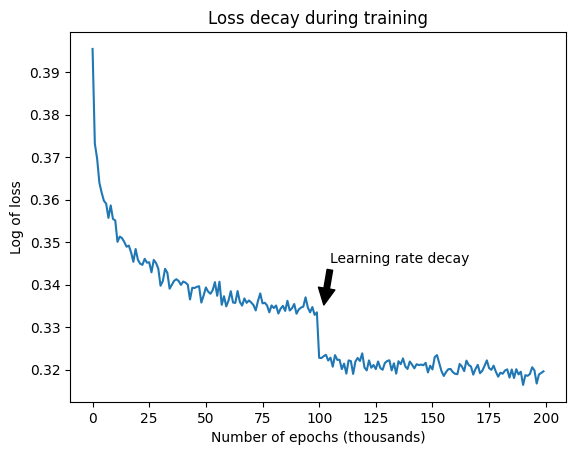

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.title("Loss decay during training")
plt.xlabel("Number of epochs (thousands)")
plt.ylabel("Log of loss")

plt.annotate('Learning rate decay',
             xy=(102, 0.335),
             xytext=(105, 0.345),
             arrowprops=dict(facecolor='black', shrink=0.02)) 

## 1.5. Evaluation step

In [13]:
performance_log = {}

for layer in base_model.layers:
  layer.training = False

@torch.no_grad()
def split_loss(model):
  tr_logits  = model(Xtr)
  val_logits = model(Xval)
  te_logits  = model(Xte)

  performance_log[model] = {
    "context_len": context_len,
    "hidden_neurons": n_hidden,
    "params": sum(p.nelement() for p in model.params()),
    "tr_loss": round(F.cross_entropy(tr_logits, ytr).item(), 4),
    "val_loss": round(F.cross_entropy(val_logits, yval).item(), 4),
    "te_loss": round(F.cross_entropy(te_logits, yte).item(), 4),
  }

  print(performance_log)
  
split_loss(base_model)

{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0685, 'val_loss': 2.1162, 'te_loss': 2.1232}}


## 1.6. Sampling from the model

In [14]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = base_model(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))
    

janellanabir.
malexy.
cia.
cobby.
adconniel.
raber.
eljoniel.
hem.
oni.
levanni.
quan.
azmarrudenayon.
kona.
ley.
aary.
chamelecklin.
devie.
cob.
takari.
macle.


# 2. Lazily scaling up context length

In [15]:
Xtr, ytr   = build_dataset(names[:n1]  , mode="tr" , context_len=8)
Xval, yval = build_dataset(names[n1:n2], mode="val", context_len=8)
Xte, yte   = build_dataset(names[n2:]  , mode="te" , context_len=8)

Xtr.shape: torch.Size([182461, 8]), ytr.shape: torch.Size([182461])
Xval.shape: torch.Size([22779, 8]), yval.shape: torch.Size([22779])
Xte.shape: torch.Size([22906, 8]), yte.shape: torch.Size([22906])


In [16]:
for X, y in zip(Xtr[:5], ytr[:5]):
  print("".join(itoch[ix.item()] for ix in X), ">", itoch[y.item()])

........ > y
.......y > a
......ya > r
.....yar > i
....yari > e


In [17]:
n_embd      = 10
n_hidden    = 200
context_len = 8

scaled_model = Sequential("scaled-model", [
  Embedding(vocab_size, n_embd), Flatten(), 
  Linear(n_embd * context_len, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [18]:
print("Number of parameters: ", sum(p.nelement() for p in scaled_model.params()))
for p in scaled_model.params():
  p.requires_grad = True

Number of parameters:  22097


In [19]:
max_steps  = 200_000
batch_size = 32
lossi      = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = scaled_model(Xb)
  loss   = F.cross_entropy(logits, yb)

  # backward pass
  for p in scaled_model.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.01
  for p in scaled_model.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.2814
  25000/ 200000: 1.8952
  50000/ 200000: 2.3980
  75000/ 200000: 2.0952
 100000/ 200000: 1.5902
 125000/ 200000: 1.6262
 150000/ 200000: 1.7623
 175000/ 200000: 1.7887
 200000/ 200000: 2.0464


In [20]:
for layer in scaled_model.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))
  layer.training = False
  
split_loss(scaled_model)

Embedding : (32, 8, 10)
Flatten : (32, 80)
Linear : (32, 200)
BatchNorm : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)
{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0685, 'val_loss': 2.1162, 'te_loss': 2.1232}, scaled-model: {'context_len': 8, 'hidden_neurons': 200, 'params': 22097, 'tr_loss': 1.9319, 'val_loss': 2.0305, 'te_loss': 2.0369}}


In [21]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = scaled_model(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

jayah.
mandix.
shaun.
rowk.
jorner.
kiria.
isaryk.
ramjilla.
zyanyah.
lucilah.
stion.
damyah.
soan.
lthon.
frenkish.
aliga.
grace.
depsalia.
alahi.
jaaviyah.


## 3. Implementing WaveNet

The architecture currently being used was proposed by [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), in which a given number of characters are fed through a single hidden layer and then the output is used to predict the next character. In the first model presented here, the context length is 3 characters and in the second model, the context length is 8 characters.

<img src="../assets/neural-prob-LM.jpg" width="400"/>

Even though additional layers could be introduced, making the neural network deeper, the model would still be compressing all the information from the input into a single vector, which is then used to predict the next character.

**WaveNet**, on the other hand, is a deep generative model that is able to generate the output using a stack of *dilated causal convolutions*. This means that the output at a given time step is only dependent on the input at previous time steps, and the receptive field of the model grows exponentially with the number of layers.

<img src="../assets/wavenet.jpg" width="400"/>

### 3.1. Scratch space

Understanding the forward pass of the neural networks implemented previously and inspecting the shapes of the tensors being used.

In [22]:
# construct a batch of size 4
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, yb = Xtr[ix], ytr[ix]
Xb.shape, yb.shape

(torch.Size([4, 8]), torch.Size([4]))

In [23]:
# output shape of the first layer of the model (the Embedding layer)
scaled_model.layers[0].out.shape

torch.Size([1, 8, 10])

In [24]:
# output shape of the second layer of the model (the Flatten layer)
scaled_model.layers[1].out.shape

torch.Size([1, 80])

In [25]:
# output shape of the third layer of the model (the Linear layer)
scaled_model.layers[2].out.shape

torch.Size([1, 200])

In [26]:
# inner operation of the third layer of the model (the Linear layer)
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [27]:
# IMPORTANT: inner operation above also works with high dimensional input data (e.g. 3D)
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [28]:
# in the previous models, the input characters were flattened into a single dimension
# now, we will introduce a batch dimension to fuse the characters into two-element pairs
# eg. (1, 2) (3, 4) (5, 6) (7, 8), embedded into batch_size x 2D_pairs x n_embd tensor
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [29]:
# goal: reshape output of Embedding layer into a tensor of shape (4, 4, 20)
e = torch.randn(4, 8, 10)     # current architecture: (batch_size, context_len, n_embd)
exp_cat = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
exp_cat.shape

torch.Size([4, 4, 20])

In [30]:
(e.view(4, -1, 20) == exp_cat).all()

tensor(True)

### 3.2. Updating the Flatten layer to include batch dimension

In [31]:
class FlattenV2(Flatten):
  def __init__(self, n_elements):
    self.n_elements = n_elements

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n_elements, C * self.n_elements)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

In [32]:
n_embd = 10
n_hidden = 68     # adjust hidden layer so total number of parameters is the same of previous models

wavenet_model_v1 = Sequential("wavenet-model-v1", [
  Embedding(vocab_size, n_embd),
  FlattenV2(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [33]:
print("Number of parameters: ", sum(p.nelement() for p in wavenet_model_v1.params()))
for p in wavenet_model_v1.params():
  p.requires_grad = True

Number of parameters:  22397


### 3.3. Training the WaveNet: first pass

In [34]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = wavenet_model_v1(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in wavenet_model_v1.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.02
  for p in wavenet_model_v1.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.2903
  25000/ 200000: 2.4359
  50000/ 200000: 1.6422
  75000/ 200000: 2.0187
 100000/ 200000: 2.1975
 125000/ 200000: 2.1933
 150000/ 200000: 1.5275
 175000/ 200000: 2.1747
 200000/ 200000: 1.7174


In [35]:
for layer in wavenet_model_v1.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))
  layer.training = False
  
split_loss(wavenet_model_v1)

Embedding : (32, 8, 10)
FlattenV2 : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenV2 : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenV2 : (32, 136)
Linear : (32, 68)
BatchNorm : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)
{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0685, 'val_loss': 2.1162, 'te_loss': 2.1232}, scaled-model: {'context_len': 8, 'hidden_neurons': 200, 'params': 22097, 'tr_loss': 1.9319, 'val_loss': 2.0305, 'te_loss': 2.0369}, wavenet-model-v1: {'context_len': 8, 'hidden_neurons': 68, 'params': 22397, 'tr_loss': 1.9525, 'val_loss': 2.0256, 'te_loss': 2.044}}


In [36]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = wavenet_model_v1(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

banitter.
daverly.
aivany.
cermie.
cynni.
ataleya.
eristyn.
ruberfo.
kinlee.
jaire.
ruhhyn.
arahir.
makor.
alizela.
barattin.
dekse.
mykana.
marvaci.
kaimiyah.
deyonn.


### 3.4. Updating the BatchNorm layer to include batch dimension

The Batch Normalization layer, as currently implemented, is receiving a 2D tensor of shape `(batch_size, n_hidden)`. Since, in Pytorch, everything broadcasts properly, this layer is able to normalize the activations of the hidden layer. However, in the WaveNet model, the hidden layer is a 3D tensor of shape `(batch_size, context_len // dilated_causal_convolutions, n_hidden)`. This means that the Batch Normalization layer is normalizing the activations of the hidden layer along the wrong axis.

In [48]:
# how it is currently implemented...
e      = torch.randn(2, 3)                         # input of shape (2, 3)
e_mean = e.mean(0, keepdim=True)                   # batch mean of shape (1, 3)
e_var  = e.var(0, keepdim=True)                    # batch variance of shape (1, 3)
e_hat  = (e - e_mean) / torch.sqrt(e_var + 1e-5)   # normalized input of shape (2, 3)
e, e_mean, e_var, e_hat

(tensor([[-1.4956,  0.2474, -0.7903],
         [-0.7031, -0.3599, -0.4418]]),
 tensor([[-1.0993, -0.0563, -0.6161]]),
 tensor([[0.3140, 0.1844, 0.0607]]),
 tensor([[-0.7071,  0.7071, -0.7070],
         [ 0.7071, -0.7071,  0.7070]]))

In [49]:
# ...how it will incorrectly broadcast...
e      = torch.randn(2, 3, 4)                      # input of shape (2, 3, 4)
e_mean = e.mean(0, keepdim=True)                   # batch mean of shape (1, 3, 4)
e_var  = e.var(0, keepdim=True)                    # batch variance of shape (1, 3, 4)
e_hat  = (e - e_mean) / torch.sqrt(e_var + 1e-5)   # normalized input of shape (2, 3, 4)
e, e_mean, e_var, e_hat

(tensor([[[ 1.3287,  0.4370,  0.5469, -0.9049],
          [ 0.5698,  1.6174,  0.9841,  0.4329],
          [-0.0867,  0.0665,  1.2209,  0.8377]],
 
         [[ 0.0830,  0.8253, -0.7065, -1.0320],
          [-0.4697,  1.0208, -0.8714, -0.2629],
          [-1.8326,  0.0820,  0.9459,  0.0695]]]),
 tensor([[[ 0.7058,  0.6312, -0.0798, -0.9684],
          [ 0.0501,  1.3191,  0.0564,  0.0850],
          [-0.9596,  0.0743,  1.0834,  0.4536]]]),
 tensor([[[7.7596e-01, 7.5385e-02, 7.8556e-01, 8.0742e-03],
          [5.4034e-01, 1.7794e-01, 1.7215e+00, 2.4204e-01],
          [1.5242e+00, 1.2016e-04, 3.7838e-02, 2.9507e-01]]]),
 tensor([[[ 0.7071, -0.7071,  0.7071,  0.7067],
          [ 0.7071,  0.7071,  0.7071,  0.7071],
          [ 0.7071, -0.6794,  0.7070,  0.7071]],
 
         [[-0.7071,  0.7071, -0.7071, -0.7067],
          [-0.7071, -0.7071, -0.7071, -0.7071],
          [-0.7071,  0.6794, -0.7070, -0.7071]]]))

In [53]:
# ...how it should be
e      = torch.randn(2, 3, 4)                      # input of shape (2, 3, 4)
e_mean = e.mean((0, 1), keepdim=True)              # batch mean of shape (1, 1, 4)
e_var  = e.var((0, 1), keepdim=True)               # batch variance of shape (1, 1, 4)
e_hat  = (e - e_mean) / torch.sqrt(e_var + 1e-5)   # normalized input of shape (2, 3, 4)
e, e_mean, e_var, e_hat

(tensor([[[ 0.3711, -1.0470,  1.2473, -2.2059],
          [ 1.4369,  0.3064,  0.4757,  0.0254],
          [-1.1406, -1.5060, -0.3617, -0.8203]],
 
         [[ 0.0976, -0.0644,  1.4956,  0.8565],
          [ 0.6067, -1.0009,  0.6808,  0.9212],
          [ 0.4694, -0.3725, -0.3627,  0.0358]]]),
 tensor([[[ 0.3069, -0.6141,  0.5292, -0.1979]]]),
 tensor([[[0.7073, 0.4681, 0.6130, 1.3776]]]),
 tensor([[[ 0.0764, -0.6328,  0.9173, -1.7108],
          [ 1.3437,  1.3454, -0.0683,  0.1902],
          [-1.7211, -1.3036, -1.1379, -0.5303]],
 
         [[-0.2488,  0.8034,  1.2344,  0.8983],
          [ 0.3565, -0.5655,  0.1936,  0.9534],
          [ 0.1933,  0.3531, -1.1391,  0.1991]]]))

In [58]:
class BatchNormV2(BatchNorm):
  """
  This layer applies batch normalization to its input, which is a technique
  that normalizes the input to the layer, in order to make the training process
  more stable and faster.

  V2 can handle both 2D and 3D input matrices.
  """
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.beta = torch.zeros((1, dim))                  # aka shift
    self.gamma = torch.ones((1, dim))                  # aka scale

    # running statistics buffers
    self.running_mean = torch.zeros((1, dim))
    self.running_var = torch.ones((1, dim))

  def __repr__(self):
    return f"BatchNorm({self.gamma.shape}, {self.beta.shape})"

  def __call__(self, x):
    # forward pass
    if self.training:
      dim   = 0 if x.ndim == 2 else (0, 1)
      xmean = x.mean(dim, keepdim=True)                     # batch mean
      xvar  = x.var(dim, keepdim=True)                      # batch variance
    else:
      xmean = self.running_mean
      xvar  = self.running_var
    
    x_hat    = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize
    self.out = self.gamma * x_hat + self.beta             # scale and shift

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar

    return self.out

  def params(self):
    return [self.gamma, self.beta]
  

class BatchNormV2(BatchNorm):
  pass

### 3.5. Training the WaveNet: second pass

In [59]:
n_embd = 10
n_hidden = 68     

wavenet_model_v2 = Sequential("wavenet-model-v2", [
  Embedding(vocab_size, n_embd),
  FlattenV2(2), Linear(n_embd   * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [62]:
print("Number of parameters: ", sum(p.nelement() for p in wavenet_model_v2.params()))
for p in wavenet_model_v2.params():
  p.requires_grad = True

Number of parameters:  22397


In [64]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = wavenet_model_v2(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in wavenet_model_v2.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.02
  for p in wavenet_model_v2.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.2802
  25000/ 200000: 2.3674
  50000/ 200000: 2.2365
  75000/ 200000: 1.4827
 100000/ 200000: 1.7679
 125000/ 200000: 2.2758
 150000/ 200000: 2.0375
 175000/ 200000: 1.7230
 200000/ 200000: 1.9166


In [65]:
for layer in wavenet_model_v2.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))
  layer.training = False
  
split_loss(wavenet_model_v2)

Embedding : (32, 8, 10)
FlattenV2 : (32, 4, 20)
Linear : (32, 4, 68)
BatchNormV2 : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenV2 : (32, 2, 136)
Linear : (32, 2, 68)
BatchNormV2 : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenV2 : (32, 136)
Linear : (32, 68)
BatchNormV2 : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)
{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0685, 'val_loss': 2.1162, 'te_loss': 2.1232}, scaled-model: {'context_len': 8, 'hidden_neurons': 200, 'params': 22097, 'tr_loss': 1.9319, 'val_loss': 2.0305, 'te_loss': 2.0369}, wavenet-model-v1: {'context_len': 8, 'hidden_neurons': 68, 'params': 22397, 'tr_loss': 1.9525, 'val_loss': 2.0256, 'te_loss': 2.044}, wavenet-model-v2: {'context_len': 8, 'hidden_neurons': 68, 'params': 22397, 'tr_loss': 1.9237, 'val_loss': 2.0237, 'te_loss': 2.0368}}


In [67]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = wavenet_model_v2(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

ahnia.
xatay.
lyra.
janai.
mylyann.
edricco.
muhazha.
liverlin.
skite.
perzie.
kalayah.
kori.
adel.
vyonna.
treya.
kaylani.
aaris.
kiann.
akaall.
angela.


### 3.6. Scaling up WaveNet: third pass

In [68]:
n_embd = 24
n_hidden = 128     

wavenet_model_v3 = Sequential("wavenet-model-v3", [
  Embedding(vocab_size, n_embd),
  FlattenV2(2), Linear(n_embd   * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  FlattenV2(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNormV2(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, scaling=True)
])

In [69]:
print("Number of parameters: ", sum(p.nelement() for p in wavenet_model_v3.params()))
for p in wavenet_model_v3.params():
  p.requires_grad = True

Number of parameters:  76579


In [70]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, yb = Xtr[ix], ytr[ix]

  # forward pass
  logits = wavenet_model_v3(Xb)
  loss = F.cross_entropy(logits, yb)

  # backward pass
  for p in wavenet_model_v3.params():
    p.grad = None
  loss.backward()

  # update params
  lr = 0.1 if step < 100_000 else 0.02
  for p in wavenet_model_v3.params():
    p.data += -lr * p.grad

  # track stats
  if step == 0 or (step+1) % 25_000 == 0:
    print(f"{(step+1):7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      1/ 200000: 3.3056
  25000/ 200000: 2.1383
  50000/ 200000: 1.6891
  75000/ 200000: 2.2325
 100000/ 200000: 1.8008
 125000/ 200000: 1.7201
 150000/ 200000: 1.9271
 175000/ 200000: 2.0595
 200000/ 200000: 1.5532


In [71]:
for layer in wavenet_model_v3.layers:
  print(layer.__class__.__name__, ":", tuple(layer.out.shape))
  layer.training = False
  
split_loss(wavenet_model_v3)

Embedding : (32, 8, 24)
FlattenV2 : (32, 4, 48)
Linear : (32, 4, 128)
BatchNormV2 : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenV2 : (32, 2, 256)
Linear : (32, 2, 128)
BatchNormV2 : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenV2 : (32, 256)
Linear : (32, 128)
BatchNormV2 : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)
{base-model: {'context_len': 3, 'hidden_neurons': 200, 'params': 12097, 'tr_loss': 2.0685, 'val_loss': 2.1162, 'te_loss': 2.1232}, scaled-model: {'context_len': 8, 'hidden_neurons': 200, 'params': 22097, 'tr_loss': 1.9319, 'val_loss': 2.0305, 'te_loss': 2.0369}, wavenet-model-v1: {'context_len': 8, 'hidden_neurons': 68, 'params': 22397, 'tr_loss': 1.9525, 'val_loss': 2.0256, 'te_loss': 2.044}, wavenet-model-v2: {'context_len': 8, 'hidden_neurons': 68, 'params': 22397, 'tr_loss': 1.9237, 'val_loss': 2.0237, 'te_loss': 2.0368}, wavenet-model-v3: {'context_len': 8, 'hidden_neurons': 128, 'params': 76579, 'tr_loss': 1.7918, 'val_loss': 2.0002, 'te_loss': 2.0094}}


In [72]:
for _ in range(20):
  out = []
  context = [0] * context_len
  while True:
    # forward pass the neural net
    logits = wavenet_model_v3(torch.tensor(context).unsqueeze(0))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # shift context window and track samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itoch[i] for i in out))

taemar.
artheriya.
jamille.
hermoni.
dreisce.
eriyanni.
harmonie.
zack.
kathis.
shayden.
adaline.
chisaber.
sherri.
kathon.
brynlin.
nahlie.
kardier.
rossey.
jaqueline.
smulyk.


# Sources

1. [Ground truth - Building makemore Part 5: Building a wavenet, By Andrej Karpathy](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)
2. van den Oord, Aäron et al. WaveNet: A generative model for raw audio, 2016. URL: https://arxiv.org/abs/1609.03499
3. Torch.NN documentation: https://pytorch.org/docs/stable/nn.html